In [1]:
import librosa
from librosa import display
import numpy as np
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

In [2]:
% pylab inline
import matplotlib.pyplot as plt

UsageError: Line magic function `%` not found.


In [3]:
import time
import os
path = 'audio_speech_actors_01-26/'
lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        file = int(file[7:8]) - 1 
        arr = mfccs, file
        lst.append(arr)
      # If the file is not valid, skip it
      except ValueError:
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 232.21552324295044 seconds ---


In [4]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)

In [5]:
X = np.asarray(X)
y = np.asarray(y)


X.shape, y.shape

((8052, 40), (8052,))

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

In [7]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [8]:
x_traincnn.shape, x_testcnn.shape

((5394, 40, 1), (2658, 40, 1))

In [9]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

model = Sequential()

model.add(Conv1D(64, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(256, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=1e-07, decay=0.0)

In C:\Users\GPI\anaconda3\envs\ser\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\GPI\anaconda3\envs\ser\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\GPI\anaconda3\envs\ser\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\GPI\anaconda3\envs\ser\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\GPI\anaconda3\envs\ser\lib\site-packages\matplotlib\

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 40, 64)            384       
_________________________________________________________________
activation (Activation)      (None, 40, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 128)           41088     
_________________________________________________________________
activation_1 (Activation)    (None, 10, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 128)           0

In [11]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [12]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=200, validation_data=(x_testcnn, y_test))

Epoch 1/200
338/338 [==============================] - 2s 5ms/step - loss: 2.9230 - accuracy: 0.2703 - val_loss: 1.4801 - val_accuracy: 0.4857
Epoch 2/200
338/338 [==============================] - 1s 4ms/step - loss: 1.6433 - accuracy: 0.4931 - val_loss: 1.2409 - val_accuracy: 0.5730
Epoch 3/200
338/338 [==============================] - 1s 4ms/step - loss: 1.2466 - accuracy: 0.6110 - val_loss: 0.8911 - val_accuracy: 0.7058
Epoch 4/200
338/338 [==============================] - 1s 4ms/step - loss: 1.0472 - accuracy: 0.6598 - val_loss: 0.8624 - val_accuracy: 0.7178
Epoch 5/200
338/338 [==============================] - 1s 4ms/step - loss: 0.9223 - accuracy: 0.6989 - val_loss: 0.7841 - val_accuracy: 0.7400
Epoch 6/200
338/338 [==============================] - 1s 4ms/step - loss: 0.8451 - accuracy: 0.7204 - val_loss: 0.7335 - val_accuracy: 0.7423
Epoch 7/200
338/338 [==============================] - 1s 4ms/step - loss: 0.7842 - accuracy: 0.7314 - val_loss: 0.6869 - val_accuracy: 0.7464

Epoch 58/200
338/338 [==============================] - 1s 4ms/step - loss: 0.3546 - accuracy: 0.8715 - val_loss: 0.3716 - val_accuracy: 0.8668
Epoch 59/200
338/338 [==============================] - 1s 4ms/step - loss: 0.3557 - accuracy: 0.8680 - val_loss: 0.3756 - val_accuracy: 0.8555
Epoch 60/200
338/338 [==============================] - 1s 4ms/step - loss: 0.3520 - accuracy: 0.8719 - val_loss: 0.3750 - val_accuracy: 0.8638
Epoch 61/200
338/338 [==============================] - 1s 4ms/step - loss: 0.3511 - accuracy: 0.8712 - val_loss: 0.3868 - val_accuracy: 0.8585
Epoch 62/200
338/338 [==============================] - 1s 4ms/step - loss: 0.3450 - accuracy: 0.8726 - val_loss: 0.3634 - val_accuracy: 0.8672
Epoch 63/200
338/338 [==============================] - 1s 4ms/step - loss: 0.3378 - accuracy: 0.8754 - val_loss: 0.3692 - val_accuracy: 0.8668
Epoch 64/200
338/338 [==============================] - 1s 4ms/step - loss: 0.3383 - accuracy: 0.8750 - val_loss: 0.3556 - val_accuracy:

338/338 [==============================] - 1s 4ms/step - loss: 0.1750 - accuracy: 0.9403 - val_loss: 0.2787 - val_accuracy: 0.9007
Epoch 171/200
338/338 [==============================] - 1s 4ms/step - loss: 0.1715 - accuracy: 0.9396 - val_loss: 0.2957 - val_accuracy: 0.8965
Epoch 172/200
338/338 [==============================] - 1s 4ms/step - loss: 0.1708 - accuracy: 0.9366 - val_loss: 0.2861 - val_accuracy: 0.8992
Epoch 173/200
338/338 [==============================] - 1s 4ms/step - loss: 0.1760 - accuracy: 0.9401 - val_loss: 0.2894 - val_accuracy: 0.8932
Epoch 174/200
338/338 [==============================] - 1s 4ms/step - loss: 0.1717 - accuracy: 0.9414 - val_loss: 0.2842 - val_accuracy: 0.8999
Epoch 175/200
338/338 [==============================] - 1s 4ms/step - loss: 0.1680 - accuracy: 0.9412 - val_loss: 0.2839 - val_accuracy: 0.8947
Epoch 176/200
338/338 [==============================] - 1s 4ms/step - loss: 0.1695 - accuracy: 0.9418 - val_loss: 0.2886 - val_accuracy: 0.8962

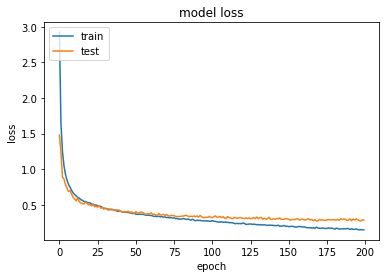

In [13]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

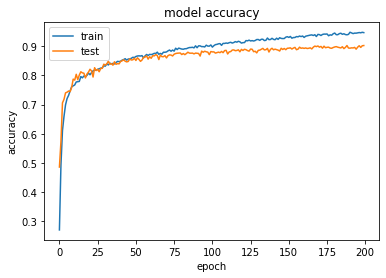

In [14]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
predictions = model.predict_classes(x_testcnn)

In [16]:
predictions

array([0, 4, 4, ..., 0, 5, 3], dtype=int64)

In [17]:
y_test

array([0, 4, 5, ..., 0, 5, 3])

In [18]:
new_Ytest = y_test.astype(int)

In [19]:
new_Ytest

array([0, 4, 5, ..., 0, 5, 3])

In [20]:
from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       328
           1       0.81      0.78      0.79       125
           2       0.93      0.90      0.91       396
           3       0.88      0.86      0.87       381
           4       0.92      0.94      0.93       384
           5       0.82      0.92      0.86       354
           6       0.91      0.95      0.93       335
           7       0.92      0.90      0.91       355

    accuracy                           0.90      2658
   macro avg       0.90      0.89      0.89      2658
weighted avg       0.90      0.90      0.90      2658



In [21]:
model.save('testing11_model.h5')
print("MODEL SAVED")

MODEL SAVED


In [22]:
new_model=keras.models.load_model('testing11_model.h5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 40, 64)            384       
_________________________________________________________________
activation (Activation)      (None, 40, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 128)           41088     
_________________________________________________________________
activation_1 (Activation)    (None, 10, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 128)           0

In [31]:
loss, acc = new_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

84/84 [==============================] - 0s 1ms/step - loss: 0.2876 - accuracy: 0.1155
Restored model, accuracy: 11.55%
